# **Prueba Técnica Desarrollador IA - Alianza Team**
> **Aspirante:** Zaida Carolina Rodríguez Navarrete
---

## **Introducción**
> 🎯 **Objetivo**: Desarrollar un modelo predictivo utilizando técnicas de machine learning (ML) para estimar la densidad de licencias comerciales por habitante en cada código postal de la ciudad de Nueva York.

### **Insumos**
| Archivo | Descripción | Fuente |
| :--- | :--- | :--- |
| `demographic-statistics-by-zip-code-1.csv` | La tabla muestra **estadísticas demográficas** de personas que participan en programas financiados por el Departamento de Desarrollo Comunitario y Juvenil de Nueva York (DYCD), organizadas por código postal. | [Demographic Statistics By Zip Code \| data.world](https://data.world/city-of-ny/kku6-nxdu) |
| `DCA_Legally_Operating_Businesses_03062015.xlsx` | Este conjunto de datos incluye licencias emitidas por el Departamento de Protección al Consumidor y al Trabajador (DCWP) a **empresas** (*Premises*) y **personas naturales** (*Individuals*) para que puedan operar legalmente en la ciudad de Nueva York. | [Legally operating businesses \| NYC Open Data](https://data.cityofnewyork.us/Business/Legally-Operating-Businesses/w7w3-xahh/about_data) |

### **Definiciones**
#### **Densidad de Licencias Comerciales**
$$ \text{Densidad de Licencias Comerciales} = \frac{\text{Número de Licencias Comerciales}}{\text{Población Total}} $$

**Nota**:
1. El número de licencias comerciales se obtiene del archivo `DCA_Legally_Operating_Businesses_03062015.xlsx`.
2. La población total se obtiene del archivo `demographic-statistics-by-zip-code-1.csv`.

## **1. Carga y preprocesamiento de datos**

In [76]:
# Importar librerías (pandas, numpy, matplotlib)
import pandas as pd

In [77]:
demographics = pd.read_csv('Sources/demographic-statistics-by-zip-code-1.csv', sep=';')
licenses = pd.read_excel('Sources/DCA_Legally_Operating_Businesses_03062015.xlsx')

print('Dimensiones de los datos de Demografía:\t', demographics.shape)
print('Dimensiones de los datos de Licencias:\t', licenses.shape)

### **Tabla 1. Demografía**

In [80]:
demographics.head()

,JURISDICTION NAME,COUNT PARTICIPANTS,COUNT FEMALE,PERCENT FEMALE,COUNT MALE,PERCENT MALE,COUNT GENDER UNKNOWN,PERCENT GENDER UNKNOWN,COUNT GENDER TOTAL,PERCENT GENDER TOTAL,...,COUNT CITIZEN STATUS TOTAL,PERCENT CITIZEN STATUS TOTAL,COUNT RECEIVES PUBLIC ASSISTANCE,PERCENT RECEIVES PUBLIC ASSISTANCE,COUNT NRECEIVES PUBLIC ASSISTANCE,PERCENT NRECEIVES PUBLIC ASSISTANCE,COUNT PUBLIC ASSISTANCE UNKNOWN,PERCENT PUBLIC ASSISTANCE UNKNOWN,COUNT PUBLIC ASSISTANCE TOTAL,PERCENT PUBLIC ASSISTANCE TOTAL
0,10001,44,22,0.50,22,0.50,0,0,44,100,...,44,100,20,0.45,24,0.55,0,0,44,100
1,10002,35,19,0.54,16,0.46,0,0,35,100,...,35,100,2,0.06,33,0.94,0,0,35,100
2,10003,1,1,1.00,0,0.00,0,0,1,100,...,1,100,0,0.00,1,1.00,0,0,1,100
3,10004,0,0,0.00,0,0.00,0,0,0,0,...,0,0,0,0.00,0,0.00,0,0,0,0
4,10005,2,2,1.00,0,0.00,0,0,2,100,...,2,100,0,0.00,2,1.00,0,0,2,100


#### Eliminación de registros innecesarios
Considerando el objetivo de este estudio, las **columnas más relevantes** para esta primera fase de preparación de los datos son:
- `JURISDICTION NAME`: Código postal. → Nos permitirá unir esta tabla con la tabla de licencias comerciales.
- `COUNT PARTICIPANTS`: Número de participantes. → Nos permitirá calcular la densidad de licencias comerciales.
    - Como se puede observar, en la _fila 4_ hay códigos postales con un recuento de participantes igual a cero.
    - Dada la definición de la densidad de licencias comerciales, estos códigos postales **no** aportarán información relevante al modelo predictivo. Por lo tanto, se procederá a **eliminar** estos registros.

In [81]:
print("Registros por eliminar: ", demographics[demographics['COUNT PARTICIPANTS'] == 0].shape[0])
print("Registros útiles restantes: ", demographics[demographics['COUNT PARTICIPANTS'] != 0].shape[0])

Registros por eliminar:  131
Registros útiles restantes:  105


In [82]:
# Eliminar registros con 0 participantes
demographics = demographics[demographics['COUNT PARTICIPANTS'] != 0]

#### Eliminación de columnas innecesarias
Una vez eliminados los registros innecesarios, se procederá a **eliminar** las columnas que no aportan información relevante al modelo predictivo. Para empezar, se evaluarán las columnas que se encuentran en la tabla de demografía.

In [83]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 233
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   JURISDICTION NAME                    105 non-null    int64  
 1   COUNT PARTICIPANTS                   105 non-null    int64  
 2   COUNT FEMALE                         105 non-null    int64  
 3   PERCENT FEMALE                       105 non-null    float64
 4   COUNT MALE                           105 non-null    int64  
 5   PERCENT MALE                         105 non-null    float64
 6   COUNT GENDER UNKNOWN                 105 non-null    int64  
 7   PERCENT GENDER UNKNOWN               105 non-null    int64  
 8   COUNT GENDER TOTAL                   105 non-null    int64  
 9   PERCENT GENDER TOTAL                 105 non-null    int64  
 10  COUNT PACIFIC ISLANDER               105 non-null    int64  
 11  PERCENT PACIFIC ISLANDER        

A partir de esta evaluación podemos intuir que:
- Podemos presindir de las columnas de recuento (`COUNT`) y de las columnas de totales (`TOTAL`) ya que no aportan información relevante al modelo predictivo.
- Si hay columnas de ceros, se pueden eliminar ya que no aportan información relevante al modelo predictivo.

In [84]:
# Eliminar columnas con 0 participantes, con totales y con conteos.
demographics = demographics.drop(columns=[col for col in demographics.columns if 'COUNT' in col and col != 'COUNT PARTICIPANTS'])
demographics = demographics[demographics.columns.drop(list(demographics.filter(regex='TOTAL')))]
demographics = demographics.loc[:, (demographics != 0).any(axis=0)]

Como resultado, se eliminaron 29 columnas de la tabla de demografía.

In [85]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 233
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   JURISDICTION NAME                    105 non-null    int64  
 1   COUNT PARTICIPANTS                   105 non-null    int64  
 2   PERCENT FEMALE                       105 non-null    float64
 3   PERCENT MALE                         105 non-null    float64
 4   PERCENT PACIFIC ISLANDER             105 non-null    float64
 5   PERCENT HISPANIC LATINO              105 non-null    float64
 6   PERCENT AMERICAN INDIAN              105 non-null    float64
 7   PERCENT ASIAN NON HISPANIC           105 non-null    float64
 8   PERCENT WHITE NON HISPANIC           105 non-null    float64
 9   PERCENT BLACK NON HISPANIC           105 non-null    float64
 10  PERCENT OTHER ETHNICITY              105 non-null    float64
 11  PERCENT ETHNICITY UNKNOWN       

> 🔍 **Observaciones**
> - En líneas generales puede verse que las 17 columnas, aquellas de `PERCENT`, son las que pueden ser usadas como predictores para el modelo.
> - Las columnas `PERCENT` contienen información de las siguientes 4 características demográficas:
>    - **Gender**: {`FEMALE`, `MALE`}
>    - **Ethnicity**: {`PACIFIC ISLANDER`, `HISPANIC LATINO`, `AMERICAN INDIAN`, `ASIAN NON HISPANIC`, `WHITE NON HISPANIC`, `BLACK NON HISPANIC`, `OTHER`, `UNKNOWN`}
>    - **Citizenship Status**: {`PERMANENT RESIDENT ALIEN`, `US CITIZEN`, `OTHER`}
>    - **Public Assistance**: {`RECEIVES PUBLIC ASSISTANCE`, `DOES NOT RECEIVE PUBLIC ASSISTANCE`}

👁️ <span style="background-color: #FFA500; color: black;">**Nota:**</span>
- En consecuencia, debemos revisar si existe multicolinearidad entre las columnas.
- Además, por claridad, se renombrarán las columnas de la tabla de demografía.

In [86]:
# Renombrar columnas de género, etnicidad, estatus de ciudadanía y asistencia pública
demographics = demographics.rename(columns=lambda x: x.replace('PERCENT ', ''))
demographics.rename(columns={'FEMALE': 'GENDER_FEMALE', 'MALE': 'GENDER_MALE'}, inplace=True)
demographics.rename(
    columns={
        'PACIFIC ISLANDER': 'ETHNICITY_PACIFIC_ISLANDER',
        'HISPANIC LATINO': 'ETHNICITY_HISPANIC_LATINO',
        'AMERICAN INDIAN': 'ETHNICITY_AMERICAN_INDIAN',
        'ASIAN NON HISPANIC': 'ETHNICITY_ASIAN_NON_HISPANIC',
        'WHITE NON HISPANIC': 'ETHNICITY_WHITE_NON_HISPANIC',
        'BLACK NON HISPANIC': 'ETHNICITY_BLACK_NON_HISPANIC',
        'OTHER ETHNICITY': 'ETHNICITY_OTHER',
        'ETHNICITY UNKNOWN': 'ETHNICITY_UNKNOWN'
    },
    inplace=True
)
demographics.rename(
    columns={
        'PERMANENT RESIDENT ALIEN': 'CITIZENSHIP_PERMANENT_RESIDENT_ALIEN',
        'US CITIZEN': 'CITIZENSHIP_US_CITIZEN',
        'OTHER CITIZEN STATUS': 'CITIZENSHIP_OTHER'
    },
    inplace=True
)
demographics.rename(
    columns={
        'RECEIVES PUBLIC ASSISTANCE': 'PUBLIC_ASSISTANCE_YES',
        'NRECEIVES PUBLIC ASSISTANCE': 'PUBLIC_ASSISTANCE_NO'
    },
    inplace=True
)

In [87]:
demographics.columns

Index(['JURISDICTION NAME', 'COUNT PARTICIPANTS', 'GENDER_FEMALE',
       'GENDER_MALE', 'ETHNICITY_PACIFIC_ISLANDER',
       'ETHNICITY_HISPANIC_LATINO', 'ETHNICITY_AMERICAN_INDIAN',
       'ETHNICITY_ASIAN_NON_HISPANIC', 'ETHNICITY_WHITE_NON_HISPANIC',
       'ETHNICITY_BLACK_NON_HISPANIC', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN',
       'CITIZENSHIP_PERMANENT_RESIDENT_ALIEN', 'CITIZENSHIP_US_CITIZEN',
       'CITIZENSHIP_OTHER', 'PUBLIC_ASSISTANCE_YES', 'PUBLIC_ASSISTANCE_NO'],
      dtype='object')

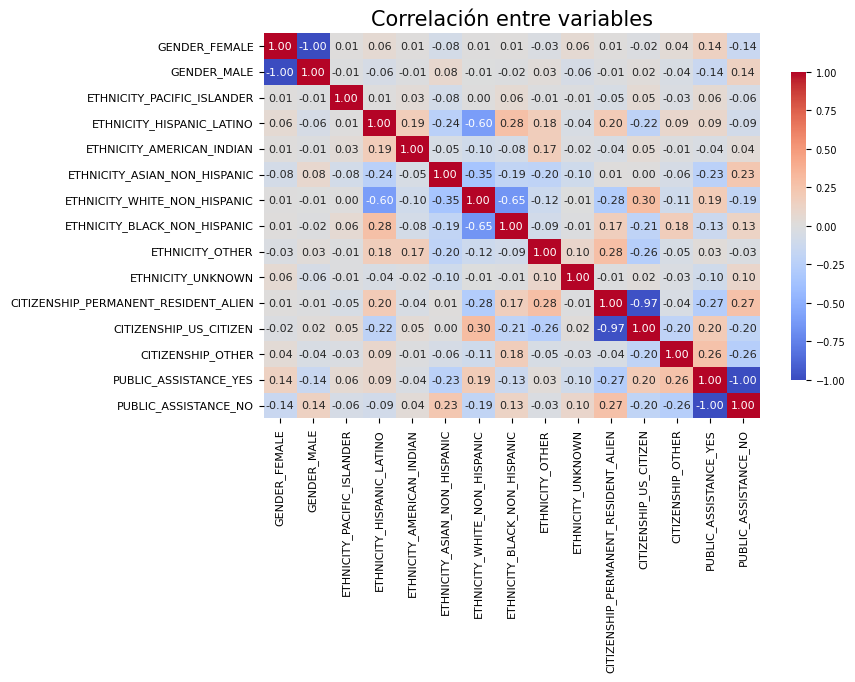

In [88]:
# Evaluar posible colinealidad entre variables
demographics_corr = demographics.drop(columns=['JURISDICTION NAME', 'COUNT PARTICIPANTS'])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
ax = sns.heatmap(demographics_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)
plt.title('Correlación entre variables', fontsize=15)
plt.show()


In [89]:
demographics_corr.corr()

,GENDER_FEMALE,GENDER_MALE,ETHNICITY_PACIFIC_ISLANDER,ETHNICITY_HISPANIC_LATINO,ETHNICITY_AMERICAN_INDIAN,ETHNICITY_ASIAN_NON_HISPANIC,ETHNICITY_WHITE_NON_HISPANIC,ETHNICITY_BLACK_NON_HISPANIC,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,CITIZENSHIP_PERMANENT_RESIDENT_ALIEN,CITIZENSHIP_US_CITIZEN,CITIZENSHIP_OTHER,PUBLIC_ASSISTANCE_YES,PUBLIC_ASSISTANCE_NO
GENDER_FEMALE,1.00,-1.00,0.01,0.06,0.01,-0.08,0.01,0.01,-0.03,0.06,0.01,-0.02,0.04,0.14,-0.14
GENDER_MALE,-1.00,1.00,-0.01,-0.06,-0.01,0.08,-0.01,-0.02,0.03,-0.06,-0.01,0.02,-0.04,-0.14,0.14
ETHNICITY_PACIFIC_ISLANDER,0.01,-0.01,1.00,0.01,0.03,-0.08,0.00,0.06,-0.01,-0.01,-0.05,0.05,-0.03,0.06,-0.06
ETHNICITY_HISPANIC_LATINO,0.06,-0.06,0.01,1.00,0.19,-0.24,-0.60,0.28,0.18,-0.04,0.20,-0.22,0.09,0.09,-0.09
ETHNICITY_AMERICAN_INDIAN,0.01,-0.01,0.03,0.19,1.00,-0.05,-0.10,-0.08,0.17,-0.02,-0.04,0.05,-0.01,-0.04,0.04
ETHNICITY_ASIAN_NON_HISPANIC,-0.08,0.08,-0.08,-0.24,-0.05,1.00,-0.35,-0.19,-0.20,-0.10,0.01,0.00,-0.06,-0.23,0.23
ETHNICITY_WHITE_NON_HISPANIC,0.01,-0.01,0.00,-0.60,-0.10,-0.35,1.00,-0.65,-0.12,-0.01,-0.28,0.30,-0.11,0.19,-0.19
ETHNICITY_BLACK_NON_HISPANIC,0.01,-0.02,0.06,0.28,-0.08,-0.19,-0.65,1.00,-0.09,-0.01,0.17,-0.21,0.18,-0.13,0.13
ETHNICITY_OTHER,-0.03,0.03,-0.01,0.18,0.17,-0.20,-0.12,-0.09,1.00,0.10,0.28,-0.26,-0.05,0.03,-0.03
ETHNICITY_UNKNOWN,0.06,-0.06,-0.01,-0.04,-0.02,-0.10,-0.01,-0.01,0.10,1.00,-0.01,0.02,-0.03,-0.10,0.10


In [90]:
demographics_corr.columns

Index(['GENDER_FEMALE', 'GENDER_MALE', 'ETHNICITY_PACIFIC_ISLANDER',
       'ETHNICITY_HISPANIC_LATINO', 'ETHNICITY_AMERICAN_INDIAN',
       'ETHNICITY_ASIAN_NON_HISPANIC', 'ETHNICITY_WHITE_NON_HISPANIC',
       'ETHNICITY_BLACK_NON_HISPANIC', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN',
       'CITIZENSHIP_PERMANENT_RESIDENT_ALIEN', 'CITIZENSHIP_US_CITIZEN',
       'CITIZENSHIP_OTHER', 'PUBLIC_ASSISTANCE_YES', 'PUBLIC_ASSISTANCE_NO'],
      dtype='object')

En el correlograma se pueden observar las siguientes correlaciones:
- GENDER_FEMALE Y GENDER MALE tienen una correlación perfecta de -1. → Se puede eliminar una de las dos columnas.
- PUBLIC_ASSISTANCE_YES y PUBLIC_ASSISTANCE_NO tienen una correlación perfecta de -1. → Se puede eliminar una de las dos columnas.
- CITIZENSHIP_PERMANENT_RESIDENT_ALIEN y CITIZENSHIP_US_CITIZEN tienen una correlación casi perfecta. → Se puede eliminar una de las dos columnas así como CITIZENSHIP_OTHER.

In [91]:
# Eliminar las columnas GENDER_MALE, PUBLIC_ASSISTANCE_NO para evitar colinealidad
demographics = demographics.drop(columns=['GENDER_MALE', 'PUBLIC_ASSISTANCE_NO'])

# Además, se eliminarán las columnas CITIZENSHIP_PERMANENT_RESIDENT_ALIEN y CITIZENSHIP_OTHER para evitar colinealidad
demographics = demographics.drop(columns=['CITIZENSHIP_PERMANENT_RESIDENT_ALIEN', 'CITIZENSHIP_OTHER'])

# También, se eliminarán las columnas 'ETHNICITY_UNKNOWN', 'ETHNICITY_AMERICAN_INDIAN', 'ETHNICITY_PACIFIC_ISLANDER', 'ETHNICITY_OTHER' por su poca correlación con la variable objetivo
demographics = demographics.drop(columns=['ETHNICITY_UNKNOWN', 'ETHNICITY_AMERICAN_INDIAN', 'ETHNICITY_PACIFIC_ISLANDER', 'ETHNICITY_OTHER'])

### **Tabla 2. Licencias Comerciales**
#### Eliminación de registros innecesarios

Considerando el objetivo de este estudio, las **columnas más relevantes** para la preparación de los datos son:
- `LICENSE_TYPE`: Tipo de licencia.
- `ZIP`: Código postal. → Nos permitirá unir esta tabla con la tabla de demografía.

In [92]:
licenses.sample(8, random_state=9).sort_values(by='LICENSE_TYPE')

,LICENSE_NBR,LICENSE_TYPE,LIC_EXPIR_DD,INDUSTRY,BUSINESS_NAME,BUSINESS_NAME2,BUILDING,STREET,STREET_2,CITY,STATE,ZIP,PHONE,BOROUGH
32723,1120701-DCA,Individual,2017-02-28 00:00:00.000,Home Improvement Salesperson,"CHUN, MIN G",NaN,NaN,NaN,NaN,FLUSHING,NY,NaN,NaN,NaN
37102,0976248-DCA,Individual,2017-02-28 00:00:00.000,Home Improvement Salesperson,"MIELESZKO, JAROSLAW",NaN,NaN,NaN,NaN,MANHASSET,NY,NaN,NaN,NaN
46769,0794375-DCA,Individual,2015-05-31 00:00:00.000,Locksmith,"GONZALEZ, ANTHONY",NaN,NaN,NaN,NaN,PEARL RIVER,NY,NaN,NaN,NaN
51906,1350201-DCA,Individual,2016-02-28 00:00:00.000,Process Server Individual,"PRINGLE, FREDERICK JOSEPH",NaN,NaN,NaN,NaN,BRONX,NY,NaN,NaN,NaN
3397,1462240-DCA,Premise,2016-12-31 00:00:00.000,Cigarette Retail Dealer,BMI DELI & GROCERY CORP,NaN,665,ONDERDONK AVE,NaN,RIDGEWOOD,NY,11385,3477983613,Queens
59368,1307588-DCA,Premise,2015-12-15 00:00:00.000,Sidewalk Cafe,480 REST AMSTERDAM INC.,NaN,480,AMSTERDAM AVE,NaN,NEW YORK,NY,10024,2125794299,Manhattan
61117,1339002-DCA,Premise,2016-03-31 00:00:00.000,Stoop Line Stand,"DOLORES CONVENIENCE & GROCERY, INC.",NaN,3967,61ST ST,NaN,WOODSIDE,NY,11377,718-457-3182,Queens
62567,1376598-DCA,Premise,2016-03-31 00:00:00.000,Stoop Line Stand,"WHOLE FOODS MARKET GROUP, INC.",NaN,270,GREENWICH ST,NaN,NEW YORK,NY,10007,2123496555,Manhattan


Aparentemente, las licencias comerciales emitidas a individuos no tienen un código postal asignado. Vamos a validar esa hipótesis:

In [93]:
nulos_no_nulos = licenses.groupby('LICENSE_TYPE')['ZIP'].apply(lambda x: pd.Series({
    'No Nulos': x.notnull().sum(),
    'Nulos': x.isnull().sum()
})).unstack().fillna(0)

# Mostrar el resultado
print(nulos_no_nulos)

              No Nulos  Nulos
LICENSE_TYPE                 
Individual           0  20359
Premise          45409     30


- Como se puede observar, solo las licencias comerciales emitidas a empresas tienen un código postal asignado.
- Por simplicidad, se eliminarán los registros que no tengan un código postal asignado, ya que la idea es poder conectar las tablas `demographics` y `licenses` a través de este campo.

In [94]:
# Eliminamos registros con valores nulos en la columna 'ZIP' → 45409
licenses = licenses.dropna(subset=['ZIP'])
licenses.shape

(45409, 14)

Además, considerando que los códigos postales de la tabla `demographics` son valores enteros, se eliminarán los registros con códigos postales no enteros.

In [95]:
# Eliminar registros con códigos postales no enteros y convertir la columna 'ZIP' a tipo de dato entero
licenses = licenses[licenses['ZIP'].str.isnumeric()].astype({'ZIP': 'int64'})
licenses.shape

(45401, 14)

#### Eliminación de columnas innecesarias
Más que eliminar columnas innecesarias, necesitamos hacer un resúmen para hallar el número de licencias comerciales por código postal que nos permitirá calcular la densidad de licencias comerciales.

In [96]:
# Recuento de licencias por código postal convertir en df con columnas 'ZIP' y 'COUNT LICENSES'
licenseStats = licenses.groupby('ZIP').size().reset_index(name='COUNT_OF_LICENSES')
licenseStats.sample(5, random_state=9)

,ZIP,COUNT_OF_LICENSES
628,11575,7
1092,50266,1
1062,44444,2
1395,95762,1
993,33870,1


### **Tabla 3. Unión de Tablas**

In [97]:
# Unir tablas de datos de demografía y licencias
data = pd.merge(demographics, licenseStats, left_on='JURISDICTION NAME', right_on='ZIP', how='inner')
data = data.drop(columns=['ZIP'])

In [98]:
data.head()

,JURISDICTION NAME,COUNT PARTICIPANTS,GENDER_FEMALE,ETHNICITY_HISPANIC_LATINO,ETHNICITY_ASIAN_NON_HISPANIC,ETHNICITY_WHITE_NON_HISPANIC,ETHNICITY_BLACK_NON_HISPANIC,CITIZENSHIP_US_CITIZEN,PUBLIC_ASSISTANCE_YES,COUNT_OF_LICENSES
0,10001,44,0.50,0.36,0.07,0.02,0.48,0.95,0.45,515
1,10002,35,0.54,0.03,0.80,0.17,0.00,0.94,0.06,441
2,10003,1,1.00,0.00,1.00,0.00,0.00,1.00,0.00,483
3,10005,2,1.00,0.00,0.50,0.00,0.50,0.50,0.00,63
4,10006,6,0.33,0.33,0.00,0.17,0.50,1.00,0.00,30


#### Creación de la variable objetivo: Densidad de Licencias Comerciales

In [99]:
# Crear una nueva columna 'LICENSES_PER_CAPITA' que muestre la cantidad de licencias por participante
data['LICENSES_PER_CAPITA'] = data['COUNT_OF_LICENSES'] / data['COUNT PARTICIPANTS']

In [100]:
# Eliminar columnas 'COUNT_OF_LICENSES' y 'COUNT PARTICIPANTS' para evitar redundancia
data = data.drop(columns=['COUNT_OF_LICENSES', 'COUNT PARTICIPANTS'])

# Convertir 'JURISDICTION NAME' a 'ZIP CODE' y hacerlo el índice
data = data.rename(columns={'JURISDICTION NAME': 'ZIP CODE'}).set_index('ZIP CODE')

In [101]:
data.shape

(85, 8)

## 2. **Análisis Exploratorio de Datos (EDA)**

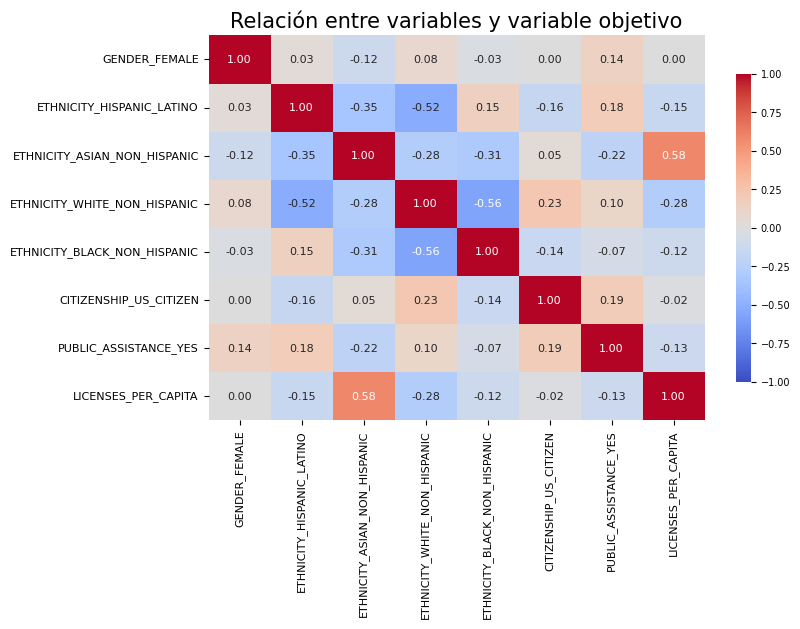

In [102]:
# Evaluar relación entre variables y variable objetivo
demographics_corr = data.copy()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
ax = sns.heatmap(demographics_corr.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=7)
plt.title('Relación entre variables y variable objetivo', fontsize=15)
plt.show()


In [103]:
demographics_corr.corr()

,GENDER_FEMALE,ETHNICITY_HISPANIC_LATINO,ETHNICITY_ASIAN_NON_HISPANIC,ETHNICITY_WHITE_NON_HISPANIC,ETHNICITY_BLACK_NON_HISPANIC,CITIZENSHIP_US_CITIZEN,PUBLIC_ASSISTANCE_YES,LICENSES_PER_CAPITA
GENDER_FEMALE,1.00,0.03,-0.12,0.08,-0.03,0.00,0.14,0.00
ETHNICITY_HISPANIC_LATINO,0.03,1.00,-0.35,-0.52,0.15,-0.16,0.18,-0.15
ETHNICITY_ASIAN_NON_HISPANIC,-0.12,-0.35,1.00,-0.28,-0.31,0.05,-0.22,0.58
ETHNICITY_WHITE_NON_HISPANIC,0.08,-0.52,-0.28,1.00,-0.56,0.23,0.10,-0.28
ETHNICITY_BLACK_NON_HISPANIC,-0.03,0.15,-0.31,-0.56,1.00,-0.14,-0.07,-0.12
CITIZENSHIP_US_CITIZEN,0.00,-0.16,0.05,0.23,-0.14,1.00,0.19,-0.02
PUBLIC_ASSISTANCE_YES,0.14,0.18,-0.22,0.10,-0.07,0.19,1.00,-0.13
LICENSES_PER_CAPITA,0.00,-0.15,0.58,-0.28,-0.12,-0.02,-0.13,1.00


> **Correlaciones con la variable objetivo (LICENSES_PER_CAPITA):**
>- ETHNICITY_ASIAN_NON_HISPANIC muestra una correlación positiva moderada de 0.58, sugiriendo que áreas con mayor población asiática no hispana tienden a tener más licencias comerciales por habitante.
>- ETHNICITY_WHITE_NON_HISPANIC tiene una correlación negativa moderada de -0.279, indicando que áreas con mayor población blanca no hispana tienden a tener menos licencias comerciales.
---
> **Correlaciones entre predictores:**
>- Hay una fuerte correlación negativa entre ETHNICITY_HISPANIC_LATINO y ETHNICITY_WHITE_NON_HISPANIC (-0.517) y entre ETHNICITY_BLACK_NON_HISPANIC y ETHNICITY_WHITE_NON_HISPANIC (-0.565), sugiriendo posible multicolinealidad entre estas variables étnicas.

Por lo tanto, en el modelamiento se intentarán diferentes estrategias para mitigar la multicolinealidad.

c:\Users\zaida\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


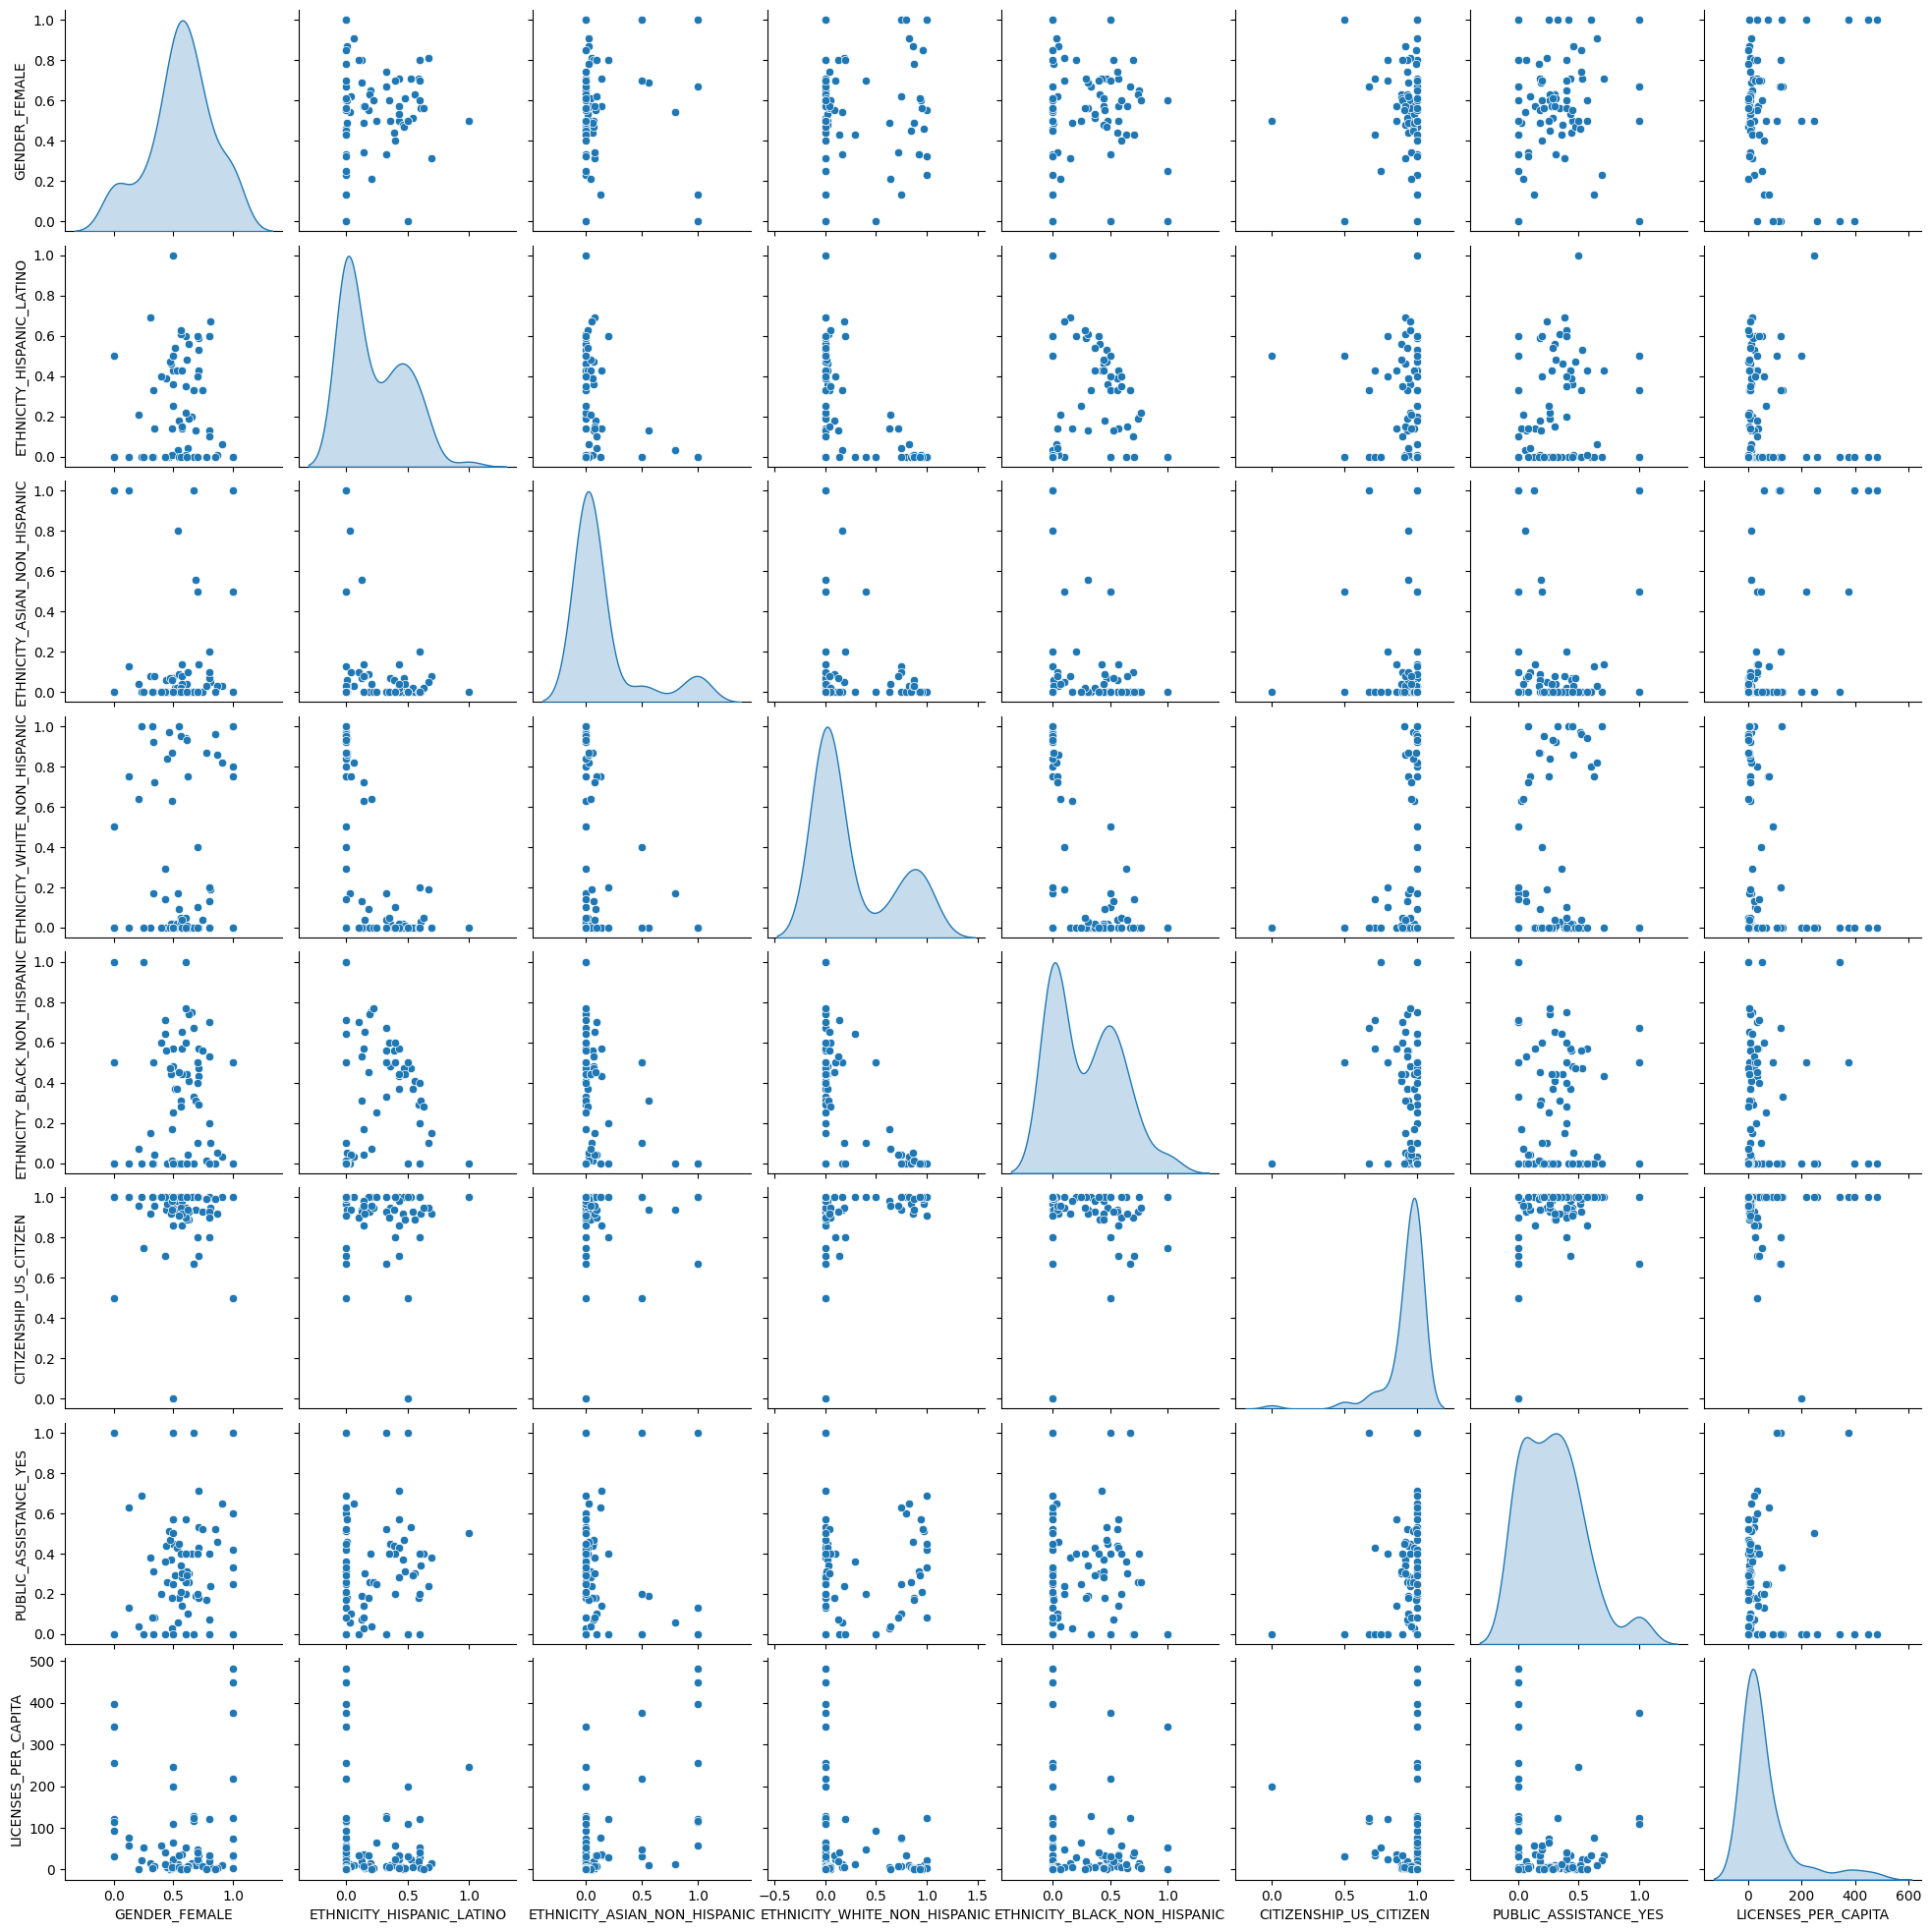

In [104]:
# hacer pairplot
sns.pairplot(data, kind='scatter', diag_kind='kde')
plt.show()

In [105]:
data.columns

Index(['GENDER_FEMALE', 'ETHNICITY_HISPANIC_LATINO',
       'ETHNICITY_ASIAN_NON_HISPANIC', 'ETHNICITY_WHITE_NON_HISPANIC',
       'ETHNICITY_BLACK_NON_HISPANIC', 'CITIZENSHIP_US_CITIZEN',
       'PUBLIC_ASSISTANCE_YES', 'LICENSES_PER_CAPITA'],
      dtype='object')

## **3. Modelamiento**

Antes de empezar a modelar hay que entender las características principales de la base de datos:
- La base de datos tiene 85 registros y 9 columnas, de las cuales 8 son variables predictoras y 1 es la variable objetivo.
- La variable objetivo es continua y se llama `LICENSES_PER_CAPITA`.
- Las variables asociadas a la etnicidad presentan multicolinealidad y debe ser tratada.

> 🔴 **Consideraciones sobre bases de datos pequeñas**: <br>
> Las bases de datos pequeñas pueden llevar a modelos sobreajustados. Los modelos más complejos pueden ajustarse a los datos de entrenamiento, pero no generalizarán bien a nuevos datos. Por lo tanto, se debe tener cuidado al seleccionar el modelo y es preferible optar por modelos más simples.


In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_models(models, X, y, test_size=0.2, cv=5, random_state=11):
    '''
        Evaluar modelos de regresión con validación cruzada y conjunto de prueba

        Parámetros:
        models (dict): Diccionario de modelos de regresión
        X (DataFrame): Variables independientes
        y (Series): Variable dependiente
        test_size (float): Proporción de datos de prueba
        cv (int): Número de divisiones en validación cruzada
        random_state (int): Semilla aleatoria

        Retorna:
        results (dict): Diccionario con métricas de evaluación de los modelos
    '''
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    results = {}
    
    # Evaluar cada modelo
    for name, model in models.items():

        # Para los modelos sensibles a la escala, crear un pipeline para escalar los datos y ajustar el modelo.
        if name in ['PCR', 'PLS']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

        # Para los modelos no sensibles a la escala
        else:
            scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calcular métricas de desempeño de los modelos
        mse_test = mean_squared_error(y_test, y_pred)
        rmse_test = mse_test**0.5
        mae_test = mean_absolute_error(y_test, y_pred)
        evs_test = explained_variance_score(y_test, y_pred)
        
        # Guardar los resultados
        results[name] = {
            # 'mean_cv_score': scores.mean(),
            # 'std_cv_score': scores.std(),
            'mse_test': mse_test,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'explained_variance_score': evs_test
        }
    return results


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_models(models, X, y, test_size=0.2, n_splits=5, n_repeats=10, random_state=30):
    '''
        Evaluar modelos de regresión con Repeated Cross-Validation y conjunto de prueba

        Parámetros:
        models (dict): Diccionario de modelos de regresión
        X (DataFrame): Variables independientes
        y (Series): Variable dependiente
        test_size (float): Proporción de datos de prueba
        n_splits (int): Número de divisiones en validación cruzada (k en k-fold)
        n_repeats (int): Número de repeticiones en Repeated Cross-Validation
        random_state (int): Semilla aleatoria

        Retorna:
        results (dict): Diccionario con métricas de evaluación de los modelos
    '''
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    results = {}

    # Configurar el Repeated K-Fold Cross-Validation
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    # Evaluar cada modelo
    for name, model in models.items():

        # Para los modelos sensibles a la escala, crear un pipeline para escalar los datos y ajustar el modelo.
        if name in ['PCR', 'PLS']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            scores = cross_val_score(pipeline, X_train, y_train, cv=rkf, scoring='neg_mean_squared_error')
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

        # Para los modelos no sensibles a la escala
        else:
            scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring='neg_mean_squared_error')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calcular métricas de desempeño de los modelos
        mse_test = mean_squared_error(y_test, y_pred)
        rmse_test = mse_test**0.5
        mae_test = mean_absolute_error(y_test, y_pred)
        evs_test = explained_variance_score(y_test, y_pred)
        
        # Guardar los resultados
        results[name] = {
            # 'mean_cv_score': scores.mean(),
            # 'std_cv_score': scores.std(),
            'mse_test': mse_test,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'explained_variance_score': evs_test
        }
    return results


In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def evaluate_models(models, X, y, test_size=0.2, n_splits=5, n_repeats=10, random_state=30):
    '''
        Evaluar modelos de regresión con Repeated Cross-Validation y conjunto de prueba

        Parámetros:
        models (dict): Diccionario de modelos de regresión
        X (DataFrame): Variables independientes
        y (Series): Variable dependiente
        test_size (float): Proporción de datos de prueba
        n_splits (int): Número de divisiones en validación cruzada (k en k-fold)
        n_repeats (int): Número de repeticiones en Repeated Cross-Validation
        random_state (int): Semilla aleatoria

        Retorna:
        results (dict): Diccionario con métricas de evaluación de los modelos
    '''
    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    results = {}

    # Configurar el Repeated K-Fold Cross-Validation
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    # Evaluar cada modelo
    for name, model in models.items():

        # Para los modelos sensibles a la escala, crear un pipeline para escalar los datos y ajustar el modelo.
        if name in ['PCR', 'PLS']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
            scores = cross_val_score(pipeline, X_train, y_train, cv=rkf, scoring='neg_mean_squared_error')
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

        # Para los modelos no sensibles a la escala
        else:
            scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring='neg_mean_squared_error')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calcular métricas de desempeño de los modelos
        mse_test = mean_squared_error(y_test, y_pred)
        rmse_test = mse_test**0.5
        mae_test = mean_absolute_error(y_test, y_pred)
        evs_test = explained_variance_score(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)
        
        # Guardar los resultados
        results[name] = {
            'mean_cv_score': scores.mean(),
            'std_cv_score': scores.std(),
            'mse_test': mse_test,
            'rmse_test': rmse_test,
            'mae_test': mae_test,
            'explained_variance_score': evs_test,
            'r2_score': r2_test
        }
    return results


In [109]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Definir los modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Elastic Net': ElasticNet(),
    'PCR': make_pipeline(PCA(n_components=5), LinearRegression()),
    'PLS': PLSRegression(n_components=2),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [110]:
# Definir X e y
X = data.drop(columns='LICENSES_PER_CAPITA')
y = data['LICENSES_PER_CAPITA']

In [111]:
# Evaluar los modelos
results = evaluate_models(models, X, y, test_size=0.1, n_splits=5, n_repeats=10, random_state=11)

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results).T

# Ordenar los resultados por una métrica específica, por ejemplo, 'mse_test'
results_df = results_df.sort_values(by='mse_test')

# Ajustar el formato de impresión
pd.set_option('float_format', '{:,.2f}'.format)

# Imprimir el DataFrame de forma legible
print(results_df)

                   mean_cv_score  std_cv_score  mse_test  rmse_test  mae_test  \
Random Forest          -6,525.33      4,133.33  6,999.19      83.66     43.96   
Decision Tree         -11,041.43      7,021.89  8,125.14      90.14     45.82   
Lasso                  -9,079.72      5,282.52  9,905.04      99.52     57.99   
Ridge                  -8,935.02      5,333.43 10,972.07     104.75     58.67   
PCR                    -9,295.41      5,350.84 12,620.39     112.34     66.04   
PLS                    -9,319.70      5,309.50 13,958.28     118.15     63.85   
Elastic Net            -9,477.64      6,199.54 14,413.63     120.06     82.99   
Linear Regression      -9,956.06      5,663.41 15,544.50     124.68     67.17   

                   explained_variance_score  r2_score  
Random Forest                          0.64      0.58  
Decision Tree                          0.61      0.51  
Lasso                                  0.47      0.40  
Ridge                                  0.43   